# 8-13. 프로젝트: 뉴스기사 요약해보기
- 새로운 데이터셋에 대해 **추상적요약(abstractive summrization)**과 **추출적요약(extractive summarization)** 해보기

# Step 0. 필요한 패키지 불러오기
- NLTK 패키지에서 불용어 사전 다운로드
- 데이터 전처리를 위한 패키지 불러오기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=3


# Step 1. 데이터 수집하기
- 데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv) 사용
  - sunnysai12345/News_Summary(https://github.com/sunnysai12345/News_Summary)

- 데이터는 기사의 본문에 해당되는 text와 headlines 두 개 열로 구성
  - 추상적요약에는 text를 본문, headlines를 요약으로 사용
  - 추출적요약에는 text만 사용

### 1-1. 데이터 다운로드

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


- 전체 샘플 (데이터) 수: 98,401개
  - csv 파일에는 98,404개의 데이터 있음.  데이터를 읽는 과정에서 **3개의 차이**가 남 (아래에 원인 파악함)

In [3]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


### 1-2. 데이터프레임 열 이름 변경
- 교재에 있는 프로그램을 변경없이 사용하기 위해 교재와 같은 이름으로 변경

In [4]:
#데이터프레임 열 이름 변경: 교재에 있는 프로그램을 사용하기 위해 교재와 같은 이름으로 변경
data.columns = ['Summary', 'Text']
#열 이름 변경 확인
data.head()

,Summary,Text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


- csv 파일 대조 결과:
  | data 번호 (index) | csv 파일 행 번호 | 비고 |
  |:----:|:----:|:----:|
  | 0 | 2 | csv 파일은 1번행부터 시작하며 <br> 1번행은 열 이름임 |
  | 1 | 3 |  |

In [5]:
data.sample(15)

,Summary,Text
26324,US man who left baby under debris says the new...,A US man who abandoned a 5-month-old baby unde...
18227,Japan admits 1st death from 2011 Fukushima nuc...,Japan has acknowledged for the first time that...
12103,Bill Gates praises 'Condom King' for promoting...,Microsoft Co-founder Bill Gates has praised ac...
32623,India to reach 100% power target before deadli...,India is set to achieve its target of universa...
30441,NASA planet-hunting telescope captures 2 lakh ...,NASA's new planet-hunting telescope has captur...
5916,Disappointment wakes you up: Katrina on 'Thugs...,Speaking about her film 'Thugs of Hindostan' a...
62612,No dictator should ever underestimate US' reso...,"No dictator, no regime and no nation should ev..."
55830,Guests did not click Adira at b'day due to Adi...,Rani Mukerji has said that guests did not clic...
85829,"Kriti Sanon, Sushant Singh Rajput's 'Raabta' h...","'Raabta', which released on Friday, ""lacks the..."
25012,Does BJP want to convert India into Taliban st...,Slamming PM Narendra Modi for remaining silent...


- 랜덤한 15개 샘플 출력 및 확인
  - csv 파일과 대조해본 결과 index에서 차이가 남
  - 확인 결과 아래와 같이 **26, 28, 29행**이 잘못되어 있음

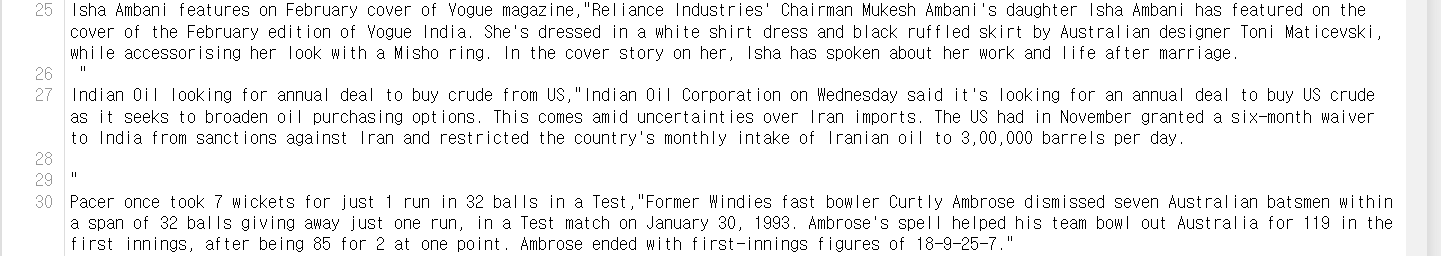

# Step 2. 데이터 전처리하기 (추상적 요약)
#### [프로젝트 지시사항]
- 실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요
- 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요

### 2-1. 중복 샘플 제거
- 중복 샘플 유무 확인

In [6]:
print('Text열에서 중복을 배제한 유일한 샘플의 수:', data['Text'].nunique())
print('Summary열에서 중복을 배제한 유일한 샘플의 수:', data['Summary'].nunique())

Text열에서 중복을 배제한 유일한 샘플의 수: 98360
Summary열에서 중복을 배제한 유일한 샘플의 수: 98280


|   | 전체 데이터 수 | Unique 데이터 수 | 조치 사항 |
|:----:|:----:|:----:|:----:|
| **Text열** | 98,401 | 98,360 | 중복 데이터 제거 필요 |
| **Summary열** | 98,401 | 98,280 | Text가 달라도 Summary는 같을 수 있으므로 별도 조치 불필요 |


- 데이터프레임의 drop_duplicates()를 사용, 중복 샘플 제거

In [7]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 2-2. Null값이 존재하는 샘플 제거
- Null 값이 있는 샘플 확인: .isnull().sum() 사용

In [8]:
print(data.isnull().sum())

Summary    0
Text       0
dtype: int64


- 없음

In [9]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 2-3. 텍스트 정규화 (Text Normalization) 준비
- 같은 의미인데도 다른 표현으로 쓰이는 단어들을 같은 표현으로 통일
- 텍스트 정규화를 위한 사전(dictionary)을 교재와 같이 구성
  - 정규화 사전 출처(https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


- 정규화 준비 완료

### 2-4. 불용어(Stopwords) 제거 준비
- 불용어(stopwords): 텍스트에는 자주 등장하지만 자연어 처리를 할 때 별 도움이 되지 않는 단어들
- NLTK(Natural Language ToolKit)에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어 제거

In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

#### [프로젝트 지시사항에 대한 조치]
- 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 **요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지** 고민해 보세요.
<br> <br>
- 프로젝트 데이터의 경우, 요약 데이터는 **신문기사 헤드라인**이며, Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 <br>
    이 **불용어들이 Summary에는 남아 있는 게 더 좋을 것으로 판단**
- 불용어에는 많은 전치사들이 포함되어 있음
- [참고] 아래는 70763번 데이터의 원문임
  - 아래 헤드라인에서 ' , '나 ' into '와 같은 전치사가 빠진다면 의미 전달이 제대로 되지 않을 것으로 판단

In [12]:
data.loc[70763]

Summary    IndusInd Bank, Bharat Financial enter into mer...
Text       Bharat Financial Inclusion (BFIL) has entered ...
Name: 70763, dtype: object

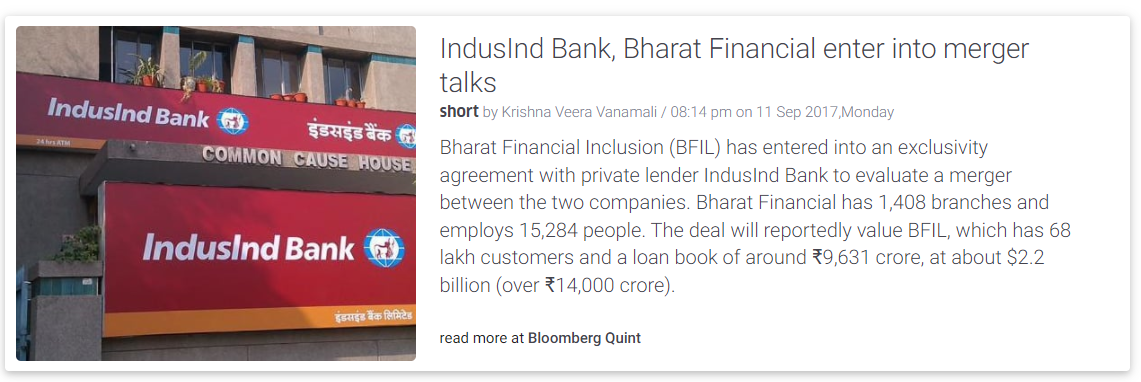

### 2-5. 기타 전처리를 포함한 데이터 전처리 함수 생성
#### [기타 전처리]
- 모든 영어 문자는 소문자로 만들기
- 섞여있을 수 있는 html 태그 제거
- 정규 표현식을 통해 각종 특수문자 제거

In [13]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    #sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    #sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    #sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub("[^a-zA-Z0-9]", " ", sentence) # 영어, 숫자 외 문자(특수문자 등) 공백으로 변환
    #sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


- 전처리 결과 확인: 임의의 text와 summary를 만들어 함수 호출 및 결과 확인

In [14]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary(불용어 미제거):", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.
print("summary(불용어 제거):", preprocess_sentence(temp_summary))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary(불용어 미제거): great way to start or finish the day
summary(불용어 제거): great way start finish day


### 2-6. 데이터 전처리 실행

- Text 전처리 후 결과 확인 (상위 5개 출력) - **불용어 제거**

In [15]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad 360 degree career support helped transition data scientist tech mahindra 90 salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending 2000 cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy 12 consecutive victories dating back march 2018 match witnessed india getting 92 seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save 46 800 taxes plan provides life cover age 100 

- Summary 전처리 후 결과 확인 (상위 5개 출력) - **불용어 미제거**

In [16]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with 90 salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india 12 match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


### 2-7. 전처리된 데이터 중 빈(empty) 샘플 유무 확인

In [17]:
# 데이터들을 데이터프레임에 재저장
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


- .isnull().sum()을 사용해서 Null 값이 있는지 확인

In [18]:
data.isnull().sum()

Summary    0
Text       0
dtype: int64

- **없음**

In [19]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 2-8. 각 데이터의 최대 크기 결정 및 최대 크기로 데이터 정제

- 훈련에 사용할 샘플의 최대 길이 결정
- Text와 Summary의 최소, 최대, 평균 길이 파악 및 길이 분포 시각화

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 36.592252948352986
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.57014030093534


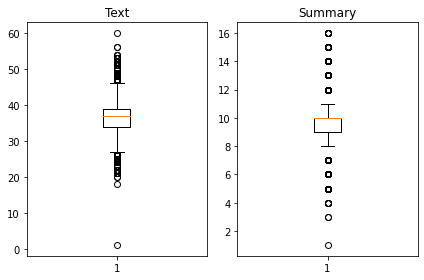

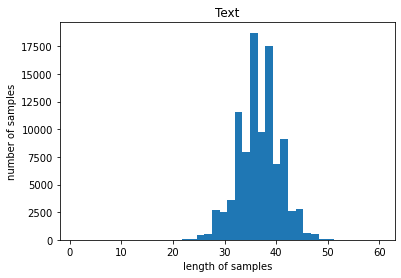

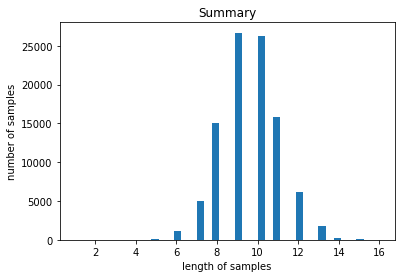

In [20]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### [결과 정리]

|   | 최소 길이 | 최대 길이 | 평균 길이 | 분포 |
|:----:|:----:|:----:|:----:|:----:|
| **Text** | 1 | 60 | 37 | 25 ~ 45 범위에 대부분 포함 |
| **Summary** | 1 | 16 | 10 | 7 ~ 12 범위에 대부분 포함 |

#### [각 데이터의 최대 길이 결정] 
- 이로부터 다음과 같이 결정:
  - Text의 최대 길이 = 45
  - Summary의 최대 길이 = 12

In [21]:
text_max_len = 45
summary_max_len = 12
print('=3')

=3


- 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수 정의

In [22]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


- 함수를 Text와 Summary에 적용

In [23]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9858275721838146
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9790056933712892


#### [각 데이터의 최대 크기로 데이터 정제]
- 최대 길이보다 긴 데이터 제외

In [24]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 94954


### 2-9. 시작토큰과 종료토큰 추가하기
- seq2seq 훈련을 위해 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가
- 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 명명하고 앞, 뒤로 추가
  - decoder_input: 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름
  - decoder_target: 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름
  - 두 개의 문장 모두 Summary 열로부터 만듦

In [25]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
# 문자열 전체 보기(show full long string in pandas DataFrame) 출처: https://signing.tistory.com/52 [끄적거림]
pd.options.display.max_colwidth = 2000
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Summary,Text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al with 90 salary hike,saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad 360 degree career support helped transition data scientist tech mahindra 90 salary hike upgrad online power learning powered lakh careers,sostoken upgrad learner switches to career in ml al with 90 salary hike,upgrad learner switches to career in ml al with 90 salary hike eostoken
2,new zealand end rohit sharma led india 12 match winning streak,new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy 12 consecutive victories dating back march 2018 match witnessed india getting 92 seventh lowest total odi cricket history,sostoken new zealand end rohit sharma led india 12 match winning streak,new zealand end rohit sharma led india 12 match winning streak eostoken
3,aegon life iterm insurance plan helps customers save tax,aegon life iterm insurance plan customers enjoy tax benefits premiums paid save 46 800 taxes plan provides life cover age 100 years also customers options insure critical illnesses disability accidental death benefit rider life cover age 80 years,sostoken aegon life iterm insurance plan helps customers save tax,aegon life iterm insurance plan helps customers save tax eostoken
5,rahat fateh ali khan denies getting notice for smuggling currency,pakistani singer rahat fateh ali khan denied receiving notice enforcement directorate allegedly smuggling foreign currency india would better authorities would served notice first publicised reads press release issued behalf rahat statement called allegation bizarre,sostoken rahat fateh ali khan denies getting notice for smuggling currency,rahat fateh ali khan denies getting notice for smuggling currency eostoken
7,govt directs alok verma to join work day before his retirement,weeks ex cbi director alok verma told department personnel training consider retired home ministry asked join work last day fixed tenure director thursday ministry directed immediately join dg fire services post transferred removal cbi chief,sostoken govt directs alok verma to join work day before his retirement,govt directs alok verma to join work day before his retirement eostoken


- 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

In [26]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


### 2-10. 훈련데이터와 테스트데이터 나누기

- encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성

In [27]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices, encoder_input[indices])

[ 4189 83613  1386 ... 26225 16341 64835] ['34 year old doctor working aiims delhi allegedly jumped death balcony house gautam nagar tuesday fight wife manish sharma reportedly inebriated state consumed sleeping pills incident police said eyewitnesses saw jump suspect foul play'
 'actress alia bhatt said denying spend time actor sidharth malhotra happy going parties spotted lunches thing friends well sidharth always special added alia'
 'afghan taliban rejected reports resuming talks us pakistan taliban said talks could resume focussed us withdrawal afghanistan exchange prisoners lifting ban movement taliban leaders taliban refused allow afghan government join negotiations aimed ending afghan war'
 ...
 'working manuscript american singer songwriter bruce springsteen 43 year old song born run sold crore 250 000 auction sotheby buyer identity disclosed seller floyd bradley duke benefactor piece expected fetch 300 000 auction earlier sold 197 000 2013'
 'bihar court ordered fir actor sal

- 정수 시퀀스를 이용해 데이터의 샘플 순서를 정의 -> 잘 섞인 샘플 생성

In [28]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


- 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
  - 전체 데이터의 크기에 0.2를 곱해서 테스트 데이터의 크기 정의

In [29]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 18990


In [30]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 75964
훈련 레이블의 개수 : 75964
테스트 데이터의 개수 : 18990
테스트 레이블의 개수 : 18990


- 훈련 데이터와 테스트 데이터(94,954개)가 각각 75,964개와 18,990개로 분리

### 2-11. 단어집합(vocabulary) 만들기와 정수 인코딩
- 각 단어에 고유한 정수를 매핑하는 작업
- Keras의 토크나이저를 사용

#### 2-11-1. Text에 대한 Vocabulary(단어집합) 만들기
- Text 훈련데이터에 대한 단어집합 만들기

In [31]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


- 현재 생성된 단어집합은 src_tokenizer.word_index에 저장
- 빈도수가 낮은 단어들은 훈련 데이터에서 제외
  - 등장 빈도수가 7회 미만(6회 이하)인 단어들의 비중 확인
  - src_tokenizer.word_counts.items()에 단어와 각 단어의 등장 빈도수가 저장되어 있음
  
<span style="color:red; font-weight:bold; font-size:20px"> [검토사항] 등장 빈도수를 7회 미만으로 하는 이유는? </span>

In [32]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어집합(vocabulary)의 크기:', total_cnt)
print('등장 빈도가 %s번 이하인 희귀단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어집합에서 희귀단어를 제외시킬 경우의 단어집합의 크기: %s'%(total_cnt - rare_cnt))
print("단어집합에서 희귀단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어집합(vocabulary)의 크기: 71320
등장 빈도가 6번 이하인 희귀단어의 수: 48519
단어집합에서 희귀단어를 제외시킬 경우의 단어집합의 크기: 22801
단어집합에서 희귀단어의 비율: 68.03000560852496
전체 등장 빈도에서 희귀단어 등장 빈도 비율: 3.5883922357265936


**[결과 분석]**
- encoder_input_train에는 7만여 개의 단어가 있음
- 등장 빈도가 6회 이하인 단어들(희귀단어)은 단어 집합에서 68% 차지
- 희귀단어가 훈련 데이터에서 등장 빈도로 차지하는 비중은 3.6%
<br> <br> 

**[조치 사항]**
- 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거
- 단어집합의 크기 결정: 71,320 - 48,519 = 22,801이므로 **단어집합의 크기를 20,000으로** 제한
  - 토크나이저 정의할 때 num_words의 값을 20,000으로 지정

In [33]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


#### 2-11-2. Text에 대한 정수 인코딩
- Text 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸기

- texts_to_sequences() 사용: 생성된 단어집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환(정수 인코딩)
  - 단어집합의 크기를 20,000으로 제한했으므로 20,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않음

In [34]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1324, 4, 15, 1525, 273, 3873, 28, 56, 2423, 183, 7542, 140, 2127, 3356, 63, 716, 169, 2446, 256, 22, 8483, 20, 4270, 3589, 8484, 149, 10, 1, 12764, 933, 3549, 1939, 5890, 298], [75, 1296, 1395, 1, 2936, 2615, 27, 50, 2990, 2361, 673, 418, 924, 1897, 1384, 835, 329, 2990, 586, 384, 3, 1296], [2321, 1940, 949, 31, 762, 5, 44, 1940, 1, 762, 87, 4529, 8485, 5, 3550, 744, 1235, 2906, 5195, 420, 1323, 1940, 441, 1940, 584, 756, 2321, 7, 1284, 4662, 925, 2755, 2321, 391]]


#### 2-11-3. Summary에 대한 단어집합 만들기 및 정수 인코딩
  - 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어집합과 각 단어에 대한 빈도수 계산

In [35]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)  # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


- 단어집합이 생성되는 동시에 각 단어에 고유한 정수 부여: tar_tokenizer.word_index에 저장
- tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장
  - 이를 통해서 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 차지하는 비중 확인
  
  <span style="color:red; font-weight:bold; font-size:20px"> [검토사항] 등장 빈도수를 6회 미만으로 하는 이유는? </span>

In [36]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31377
등장 빈도가 5번 이하인 희귀 단어의 수: 20798
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10579
단어 집합에서 희귀 단어의 비율: 66.2842209261561
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.98967933797188


**[결과 분석]**
- decoder_input_train에는 3만여 개의 단어가 있음
- 등장 빈도가 5회 이하인 단어들(희귀단어)은 단어집합에서 66% 차지
- 희귀단어가 훈련 데이터에서 등장 빈도로 차지하는 비중은 5%
<br> <br> 

**[조치 사항]**
- 등장 빈도가 5회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거
- 단어집합의 크기 결정: 31,377 - 20,798 = 10,579이므로 **단어집합의 크기를 10,000으로** 제한
  - 토크나이저 정의할 때 num_words의 값을 10,000으로 지정


In [37]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2273, 893, 1201, 3, 97, 11, 410, 8, 114, 4, 26], [1, 455, 44, 3836, 85, 72, 1829, 56, 8, 1545, 584], [1, 1250, 595, 446, 8, 13, 4, 96], [1, 3948, 6232, 2329, 4446, 2645, 321, 1236, 428, 133], [1, 916, 61, 8923, 5276, 12, 1339, 8313, 1803]]
target
decoder  [[2273, 893, 1201, 3, 97, 11, 410, 8, 114, 4, 26, 2], [455, 44, 3836, 85, 72, 1829, 56, 8, 1545, 584, 2], [1250, 595, 446, 8, 13, 4, 96, 2], [3948, 6232, 2329, 4446, 2645, 321, 1236, 428, 133, 2], [916, 61, 8923, 5276, 12, 1339, 8313, 1803, 2]]


- 정수 인코딩 작업 완료

### 2-12. 빈도수 낮은 단어 삭제로 인한 빈(empty) 샘플 찾아서 삭제
- 요약문에서 길이가 0이 된 샘플들의 인덱스 파악
  - (주의할 점) decoder_input에는 sostoken, decoder_target에는 eostoken이 추가된 상태
     - 길이가 0이 된 요약문의 실제 길이는 1
- 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test라는 변수에 저장
  - 이 샘플들은 모두 삭제

In [38]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 75964
훈련 레이블의 개수 : 75964
테스트 데이터의 개수 : 18990
테스트 레이블의 개수 : 18990


### 2-13. 패딩하기
- 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞추기
- 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이로 맞춤
- 2-8에서 결정 (text_max_len = 45, summary_max_len = 12)

In [39]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


<span style="color:blue; font-weight:bold; font-size:15px">[학습에 필요한 데이터 전처리 완료]</span>

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
#### [프로젝트 지시사항]
- 일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 
- 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

### 3-1. 인코더 설계

In [40]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256
# 인코더
encoder_inputs = Input(shape=(text_max_len,))
# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

- 임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의
  - hidden state: LSTM의 수용력(capacity)을 정하는 파라미터
    - LSTM의 용량의 크기 또는 LSTM에서의 뉴런의 개수
    - 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아님
- 인코더의 LSTM은 총 3개의 층으로 구성
- LSTM은 dropout과 recurrent dropout 사용
  - **dropout**: 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결
  - **recurrent dropout**: dropout을 레이어가 아닌 time step마다 해주는 방식. 즉 time step의 입력을 랜덤으로 생략. 일반적인 dropout와 같이 regularization(규제)을 해주며 과적합 방지
  - dropout과 recurrent dropout을 모두 사용한 것을 **Variational Dropout**이라고 함

### 3-2. 디코더 설계

#### 디코더의 임베딩 층과 LSTM 설계

In [41]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))
# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

- LSTM의 입력 정의: initial_state의 인자값으로 인코더의 hidden state와 cell state의 값 입력

#### 디코더의 출력층 설계

In [42]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 3-3. 어텐션 메커니즘 결합 디코더 출력층 수정
- TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 결합
  - Bahdanau 스타일의 어텐션 사용
- 아래와 같이 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층 수정

In [43]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])
# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

- 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용
- 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용

### 3-4. 모델 훈련하기

In [44]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
297/297 [==============================] - 201s 623ms/step - loss: 5.7633 - val_loss: 5.3146
Epoch 2/50
297/297 [==============================] - 184s 621ms/step - loss: 5.1859 - val_loss: 4.9574
Epoch 3/50
297/297 [==============================] - 184s 618ms/step - loss: 4.8478 - val_loss: 4.6995
Epoch 4/50
297/297 [==============================] - 185s 621ms/step - loss: 4.5755 - val_loss: 4.4761
Epoch 5/50
297/297 [==============================] - 184s 620ms/step - loss: 4.3611 - val_loss: 4.3406
Epoch 6/50
297/297 [==============================] - 186s 628ms/step - loss: 4.1847 - val_loss: 4.2326
Epoch 7/50
297/297 [==============================] - 183s 618ms/step - loss: 4.0354 - val_loss: 4.1262
Epoch 8/50
297/297 [==============================] - 183s 617ms/step - loss: 3.9084 - val_loss: 4.0455
Epoch 9/50
297/297 [==============================] - 183s 616ms/step - loss: 3.7921 - val_loss: 3.9960
Epoch 10/50
297/297 [==============================] - 186s 627m

- val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정
- EarlyStopping이 작동하여 epoch 29 실행 후 종료: **Epoch 00029: early stopping** <span style="color:blue; font-weight:bold; font-size:15px">(실행시마다 다름)</span>
- 총 실행시간: 약 1시간 35분 <span style="color:blue; font-weight:bold; font-size:15px">(실행시마다 다름)</span>

#### [훈련 데이터 손실 및 검증 데이터 손실 변화 시각화]

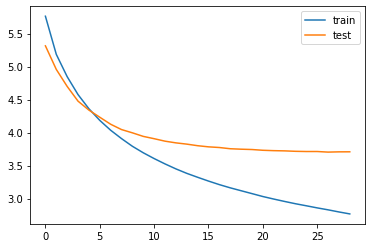

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
- 원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

### 4-1. 인퍼런스 모델 구현하기
- seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 함
- 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비
- 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 인퍼런스를 위한 모델 설계를 별도로 해야 함
  - 인코더 모델과 디코더 모델을 분리해서 설계

#### 4-1-1. 실제 데이터 복원에 필요한 3개 사전 준비

In [46]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


#### 4-1-2. 인코더 설계

In [47]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


#### 4-1-3. 어텐션 메커니즘을 사용하는 출력층(디코더) 설계

In [48]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


#### [인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 생성]

In [49]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


### 4-2. 실제 요약과 예측된 요약 비교(모델 테스트) 하기

#### [주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 생성]
- Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0 제외
- Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외

In [50]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


#### [실제 요약과 예측된 요약 비교]
- 테스트 데이터 약 50개의 샘플에 대해서 요약 비교

In [51]:
for i in range(0, 50):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : bank england governor mark carney said bitcoin pretty much failed currency said bitcoin store value map nobody uses medium exchange however cryptocurrency underlying technology may still prove useful verifying financial transactions way added 
실제 요약 : bitcoin pretty much failed as currency bank of england 
예측 요약 :  bitcoin is not bitcoin bitcoin exchange ceo


원문 : class student died thursday fight fellow students school washroom delhi police detained three students saw five students including deceased fighting inside washroom cctv footage victim fell received punches fight died later police added 
실제 요약 : class boy dies after fight at school students detained 
예측 요약 :  class boy found dead in school school in delhi


원문 : pakistan international airlines pia flight saturday landed midway lahore due low visibility asked passengers onboard travel bus destination according reports however passengers protested refused leave aircraft airline shut air conditioners leading suffocation se

예측 요약 :  video shows up govt members in up to make wedding


원문 : bengaluru based self drive vehicle rental startup reportedly last stage talks raise 60 million around 430 crore series round funding comes startup raised 20 million around 140 crore series round november founded 2015 lets vehicle owners list idle vehicles rent customers 
실제 요약 : luru vehicle rental startup to raise report 
예측 요약 :  bengaluru based grocery startup raises 10 million


원문 : talking death five civilians amid protests cm mehbooba mufti monday appealed parents ensure children embrace death adding sunday extremely sad said way needs found children army soldiers policemen killed 
실제 요약 : ensure children do not death cm to parents 
예측 요약 :  no one can be killed in kerala cm on death


원문 : talking ayodhya dispute vishva hindu parishad president vishnu said issue neither political mileage explored lord ram name issue linked elections temple issue faith hindus political parties also faith ram added 
실제 요약 : let us 

예측 요약 :  fir against lord krishna for not singing in up


원문 : pakistan rejected statement made brics nations terror groups country pose threat regional security brics nations issued declaration slamming pakistan based terror groups like jaish mohammed lashkar taiba reject declaration terrorist organization safe havens pakistan defence minister khan said 
실제 요약 : pakistan rejects brics declaration on terror groups 
예측 요약 :  pak rejects new saeed terror weapons


원문 : switzerland defeated serbia friday become first team come behind win group match 2018 fifa world cup match witnessed midfielder become third swiss player score multiple world cups midfielder became second swiss player score euro world cup 
실제 요약 : switzerland 1st team to post comeback win in 2018 fifa wc 
예측 요약 :  japan beat japan to enter world 1st wc final


원문 : windies defeated england five wickets second test register first win tests england since 2000 levelling three match series windies helped hope slammed tons inni

### 4-3. 결과 분석

#### [20개 예측 요약 분석]

1. 원문 : bank england governor mark carney said bitcoin pretty much failed currency said bitcoin store value map nobody uses medium exchange however cryptocurrency underlying technology may still prove useful verifying financial transactions way added 
- 실제 요약 : bitcoin pretty much failed as currency bank of england 
- 예측 요약 :  bitcoin is not bitcoin bitcoin exchange ceo
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>

2. 원문 : class student died thursday fight fellow students school washroom delhi police detained three students saw five students including deceased fighting inside washroom cctv footage victim fell received punches fight died later police added 
- 실제 요약 : class boy dies after fight at school students detained 
- 예측 요약 :  class boy found dead in school school in delhi
- <span style="color:blue; font-weight:bold; font-size:15px">원문에 없던 단어를 사용해서 요약</span>

3. 원문 : pakistan international airlines pia flight saturday landed midway lahore due low visibility asked passengers onboard travel bus destination according reports however passengers protested refused leave aircraft airline shut air conditioners leading suffocation several passengers reports added 
- 실제 요약 : pak int flight lands midway asks passengers to take bus 
- 예측 요약 :  pak flight forced to take back to plane engine
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>

4. 원문 : prime minister narendra modi inaugurated first ever india institute ayurveda delhi today occasion 2nd ayurveda day first institute ministry ayush national accreditation board hospitals healthcare providers accreditation institute separate yoga units among others 
- 실제 요약 : pm modi inaugurates 1st ever all india institute of 
- 예측 요약 :  pm modi inaugurates india first in india
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>

5. 원문 : upside house built city russia nearly 300 000 crore house fit least 50 people believed biggest kind curator said upside house people walking ceiling furniture even clothes hanging upside 
- 실제 요약 : upside down house comes up in russia 
- 예측 요약 :  russian town set up to sell aircraft for crore
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>
- (csv 원문) An upside-down house has been built in Ufa city, Russia. The nearly â¬300,000 (â¹2.4 crore) house can fit at least 50 people and is believed to be the biggest of its kind. Its curator said, "It is an upside-down house, people are walking on the ceiling and all the furniture is above them... even clothes are hanging upside down."

6. 원문 : pm narendra modi paytm founder vijay shekhar sharma indians named time magazine 100 influential people list 2017 modi achieved feat third time last four years featured list 2014 2015 sharma featured year list includes amazon ceo jeff bezos 
- 실제 요약 : pm paytm ceo feature in time 100 most influential people 
- 예측 요약 :  india born by pm modi times than women in 2017
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>

7. 원문 : total market valuation 100 largest companies globally increased 15 since last year 20 trillion according report auditing company pwc us retained leading position 54 companies top 100 accounting 61 total market capitalisation report said apple remained valuable company seventh straight year added 
- 실제 요약 : total market cap of top 100 firms hits 20 trillion report 
- 예측 요약 :  india biggest trillion in market cap in 2017 report
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>

8. 원문 : around 700 employees aviation ground handling agency delhi mumbai airports paid nearly years employees started agitation mumbai tuesday demanding immediate payment dues aviation founded 1954 shut 2016 owners left united states 
- 실제 요약 : unpaid for years aviation staffers protest 
- 예측 요약 :  mumbai to pay over 50 000 employees to stay
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>

9. 원문 : two time ipl champions chennai super kings returning tournament two years retained ms dhoni suresh raina ravindra jadeja ipl 2018 meanwhile royal challengers bangalore 2017 champions mumbai indians retained virat kohli rohit sharma respectively bhuvneshwar kumar david warner steven smith also retained respective franchises 
- 실제 요약 : csk retains ms dhoni rcb keeps virat kohli for ipl 2018 
- 예측 요약 :  dhoni takes wickets in ipl 2018 to be run by srh
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>

10. 원문 : us supreme court tuesday ruled immigrants face possible deportation detained indefinitely without receiving bond hearings even entered country legally seeking asylum reversed ruling san francisco based 9th us circuit court appeals set six month limit detention without bond hearings immigrants risking national security 
- 실제 요약 : us supreme court rules immigrants can be held indefinitely 
- 예측 요약 :  us court rules us court rules for us court
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>

11. 원문 : nike tuesday unveiled self smart basketball shoes adapt bb controlled app shoes contain motor gear train senses tension required user foot accordingly user tighten shoes required physical buttons shoes connected app 
- 실제 요약 : nike makes self smart shoes controlled by an app 
- 예측 요약 :  company makes robot that can be made for carrying
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>

12. 원문 : many 16 vehicles stolen every day bengaluru police able detect 27 cases 2017 city police data revealed according police vehicles stolen residential areas night commercial areas day city also gangs steal vehicles 
- 실제 요약 : 16 vehicles stolen daily in bengaluru police data 
- 예측 요약 :  10 000 people arrested for illegal in bengaluru
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>

13. 원문 : mp bai resigned bjp saying party trying create divisions society work dalits bjp nothing dalit reservation said adding continue mp till end term earlier accused bjp ram mandir issue due elections 
- 실제 요약 : bjp trying to create in society quits party 
- 예측 요약 :  bjp mp bjp leaders to resign for bjp
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>

14. 원문 : premier league leaders manchester city extended record run consecutive top flight wins 17 matches thrashing bournemouth saturday 101 goals 2017 city became first english team since liverpool 106 1982 score 100 plus goals top flight calendar year meanwhile chelsea held goalless draw everton 
- 실제 요약 : man city thrash mouth extend winning run to 17 games 
- 예측 요약 :  man utd beat arsenal to win 2nd straight pl title
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약. 없는 얘기 지어냄 ㅎㅎ</span>

15. 원문 : operator masala library restaurants massive restaurants raised reported amount 160 crore mumbai based private equity firm gaja capital round gaja capital become major minority shareholder company according reports founded 2012 chef kalra massive restaurants operates brand names including caf pa pa ya 
- 실제 요약 : masala library restaurants operator raises funding 
- 예측 요약 :  myntra buys stake in gurugram
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약. 없는 얘기 지어냄 ㅎㅎ</span>

16. 원문 : speaking congress lead rajasthan madhya pradesh chhattisgarh assembly elections party president rahul gandhi press conference said want make india mukt free anyone agree somebody fight try added rahul also thanked workers party performance elections 
- 실제 요약 : do not want to make india of anyone rahul gandhi 
- 예측 요약 :  rahul gandhi is not good for any country mp cm
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>

17. 원문 : umpires american baseball league major league baseball wore white matches protest abusive player behaviour move come detroit second ian fined suspended recent verbal umpire angel match last monday called bad umpire 
- 실제 요약 : baseball umpires wear to protest abuse by players 
- 예측 요약 :  baseball player gets notice for ball to stop umpire
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약. 없는 얘기 지어냄 ㅎㅎ</span>

18. 원문 : person killed three others sustained serious injuries following blast trinamool congress office west bengal district sunday police launched probe matter arrests made far notably locals claimed people inside office trying make bomb accidentally exploded 
- 실제 요약 : blast at tmc office kills injures in west bengal 
- 예측 요약 :  killed in blast attack on suspicion of killing in bengal
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>

19. 원문 : actor akshay kumar said marathi cinema hindi films adding content marathi cinema doubt better hindi cinema talking upcoming production said films gone festivals felt give name film content really good 
- 실제 요약 : marathi cinema is than hindi films akshay kumar 
- 예측 요약 :  film is not to be part of film fest akshay
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>

20. 원문 : actor ranveer singh said would different person actor added wanted hero hindi films today become said despite theatre background studying theory acting learnt job 
- 실제 요약 : would have been different person had not been actor ranveer 
- 예측 요약 :  ranveer singh is the best actor
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>


**[결과 분석]**
- 교재에는 
  - 실제 요약과 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들
  - 원문에 없던 단어를 사용해서 한 요약들  <br>
  이 있었다고 함
  
- 위의 20개 분석 결과 **대부분 그다지 좋지 않은 요약**임 
- 문법 완성도 측면 및 핵심 단어 포함 측면 모두에서 성능이 아주 좋지 않음

**[성능 개선 방안 (교재의 내용)]**
- seq2seq와 어텐션의 조합을 좀 더 좋게 수정하는 방법
- 빔 서치(beam search)
- 사전 훈련된 워드 임베딩(pre-trained word embedding)
- 트랜스포머(Transformer): 인코더-디코더의 구조 변경 등

# Step 5. Summa을 이용해서 추출적 요약해보기
- 추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높음
- 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮음
<br> <br>
- Summa의 summarize를 사용하여 추출적 요약을 해보세요.
  - 추출적요약에는 text만 사용

### 5-1. 필요한 패키지 불러오기

In [52]:
import requests
from summa.summarizer import summarize

### 5-2. 데이터 불러오기
- 추출적요약에는 text만 사용

In [66]:
#text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text
# print(text[:1500])
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [67]:
#데이터 확인
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."
1,Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,"New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history."
3,Aegon life iTerm insurance plan helps customers save tax,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years."
4,"Have known Hirani for yrs, what if MeToo claims are not true: Sonam","Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed."" ""In the #MeToo movement, I always believe a woman. But in this case, we need to reserve our judgment,"" she added. Hirani has been accused by an assistant who worked in 'Sanju'."


In [68]:
#데이터 확인
data['text'][0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

### 5-3. summarize 사용하기

#### [인자 설명]
- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수.
  - 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환
<br> <br>
- Summa의 summarize는 내부에서 문장 토큰화 수행 - 문장 구분이 되어있지 않은 원문 사용 가능
- 원문의 10% 또는 20 단어 이내로 출력하도록 설정

In [72]:
for i in range(0, 20):
    print("원문:", data['text'][i])
    print("실제 요약:", data['headlines'][i])
    print("Extractive 요약:", summarize(data['text'][i], ratio=0.05, words=15))
    print("\n")

원문: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약: upGrad learner switches to career in ML & Al with 90% salary hike
Extractive 요약: upGrad's Online Power Learning has powered 3 lakh+ careers.


원문: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약: Delhi techie wins free food from Swiggy for one year on CRED
Extractive 요약: Users get one CRED coin per rupee o

### 5-4. 결과 분석

#### [20개 예측 요약 분석]

1. 원문: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
- 실제 요약: upGrad learner switches to career in ML & Al with 90% salary hike
- Extractive 요약: upGrad's Online Power Learning has powered 3 lakh+ careers.
- <span style="color:blue; font-weight:bold; font-size:15px">나쁘지 않은 요약</span>

2. 원문: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
- 실제 요약: Delhi techie wins free food from Swiggy for one year on CRED
- Extractive 요약: Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
- <span style="color:blue; font-weight:bold; font-size:15px">나쁘지 않은 요약</span>

3. 원문: New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.
- 실제 요약: New Zealand end Rohit Sharma-led India's 12-match winning streak
- Extractive 요약: The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>

4. 원문: With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.
- 실제 요약: Aegon life iTerm insurance plan helps customers save tax
- Extractive 요약: Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>

5. 원문: Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, "I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed." "In the #MeToo movement, I always believe a woman. But in this case, we need to reserve our judgment," she added. Hirani has been accused by an assistant who worked in 'Sanju'.
- 실제 요약: Have known Hirani for yrs, what if MeToo claims are not true: Sonam
Extractive 요약: 
- <span style="color:blue; font-weight:bold; font-size:15px">요약 없음</span>

6. 원문: Pakistani singer Rahat Fateh Ali Khan has denied receiving any notice from the Enforcement Directorate over allegedly smuggling foreign currency out of India. "It would have been better if the authorities would have served the notice first if any and then publicised this," reads a press release issued on behalf of Rahat. The statement further called the allegation "bizarre".
- 실제 요약: Rahat Fateh Ali Khan denies getting notice for smuggling currency
- Extractive 요약: Pakistani singer Rahat Fateh Ali Khan has denied receiving any notice from the Enforcement Directorate over allegedly smuggling foreign currency out of India.
- <span style="color:blue; font-weight:bold; font-size:15px">나쁘지 않은 요약</span>

7. 원문: India recorded their lowest ODI total in New Zealand after getting all out for 92 runs in 30.5 overs in the fourth ODI at Hamilton on Thursday. Seven of India's batsmen were dismissed for single-digit scores, while their number ten batsman Yuzvendra Chahal top-scored with 18*(37). India's previous lowest ODI total in New Zealand was 108.
- 실제 요약: India get all out for 92, their lowest ODI total in New Zealand
- Extractive 요약: India's previous lowest ODI total in New Zealand was 108.
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>

8. 원문: Weeks after ex-CBI Director Alok Verma told the Department of Personnel and Training to consider him retired, the Home Ministry asked him to join work on the last day of his fixed tenure as Director on Thursday. The ministry directed him to immediately join as DG, Fire Services, the post he was transferred to after his removal as CBI chief.
- 실제 요약: Govt directs Alok Verma to join work 1 day before his retirement
- Extractive 요약: 
- <span style="color:blue; font-weight:bold; font-size:15px">요약 없음</span>

9. 원문: Andhra Pradesh CM N Chandrababu Naidu has said, "When I met then US President Bill Clinton, I addressed him as Mr Clinton, not as 'sir'. (PM Narendra) Modi is my junior in politics...I addressed him as sir 10 times." "I did this...to satisfy his ego in the hope that he will do justice to the state," he added.
- 실제 요약: Called PM Modi 'sir' 10 times to satisfy his ego: Andhra CM
- Extractive 요약: Andhra Pradesh CM N Chandrababu Naidu has said, "When I met then US President Bill Clinton, I addressed him as Mr Clinton, not as 'sir'.
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>

10. 원문: Congress candidate Shafia Zubair won the Ramgarh Assembly seat in Rajasthan, by defeating BJP's Sukhwant Singh with a margin of 12,228 votes in the bypoll. With this victory, Congress has taken its total to 100 seats in the 200-member assembly. The election to the Ramgarh seat was delayed due to the death of sitting MLA and BSP candidate Laxman Singh.
- 실제 요약: Cong wins Ramgarh bypoll in Rajasthan, takes total to 100 seats
- Extractive 요약: Congress candidate Shafia Zubair won the Ramgarh Assembly seat in Rajasthan, by defeating BJP's Sukhwant Singh with a margin of 12,228 votes in the bypoll.
- <span style="color:blue; font-weight:bold; font-size:15px">나쁘지 않은 요약</span>

11. 원문: Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. The cousins revealed their ordeal to the police and Child Welfare Committee after being brought back to Gorakhpur from Nepal, where they had fled to escape the torture.
- 실제 요약: UP cousins fed human excreta for friendship with boys
- Extractive 요약: 
- <span style="color:blue; font-weight:bold; font-size:15px">요약 없음</span>

12. 원문: Isha Ghosh, an 81-year-old member of Bharat Scouts and Guides (BSG), has been imparting physical and mental training to schoolchildren in Jharkhand for several decades. Chaibasa-based Ghosh reportedly walks seven kilometres daily and spends eight hours conducting physical training, apart from climbing and yoga sessions. She says, "One should do something for society till one's last breath."
- 실제 요약: 81-yr-old woman conducts physical training in J'khand schools
- Extractive 요약: Isha Ghosh, an 81-year-old member of Bharat Scouts and Guides (BSG), has been imparting physical and mental training to schoolchildren in Jharkhand for several decades.
- <span style="color:blue; font-weight:bold; font-size:15px">나쁘지 않은 요약</span>

13. 원문: Urging saints and seers at the Kumbh Mela to quit smoking, Yoga guru Ramdev said, "We follow Ram and Krishna who never smoked in their life then why should we?" Making them take a pledge to quit tobacco, he collected chillum (clay pipe) from several sadhus. He said he will deposit the chillums for display at a museum he'll build.
- 실제 요약: Ram, Krishna didn't smoke, why should we: Ramdev to sadhus at Kumbh
- Extractive 요약: 
- <span style="color:blue; font-weight:bold; font-size:15px">요약 없음</span>

14. 원문: Former stripper and regional sales director of a pharmaceutical company, Sunrise Lee, gave a doctor a lap dance in a nightclub to persuade him to prescribe an addictive fentanyl spray in 2012, the company's sales representative told a US court. She said she saw Lee "sitting on [doctor's] lap, kind of bouncing around." Lee has been accused of bribing doctors.
- 실제 요약: Pharma exec gave doctor a lap dance to sell medicine in US: Witness
- Extractive 요약: 
- <span style="color:blue; font-weight:bold; font-size:15px">요약 없음</span>

15. 원문: Reliance Industries' Chairman Mukesh Ambani's daughter Isha Ambani, who got married last month, said she only cried at her 'bidaai' because she felt peer pressure as everyone was crying, especially her parents. "I was emotional too but everyone around me would cry all the time," she added. "It was a very emotional affair for everyone in my family," said Isha.
- 실제 요약:  I only cried at my 'bidaai' as I felt peer pressure: Isha Ambani
- Extractive 요약: "It was a very emotional affair for everyone in my family," said Isha.
- <span style="color:blue; font-weight:bold; font-size:15px">그다지 좋지 않은 요약</span>

16. 원문: Louis Vuitton owner LVMH, which makes high-end beverages like MoÃÂ«t & Chandon champagne and Hennessy cognac, said it's stockpiling four months' worth of wine and spirits in UK in preparation for Brexit. "We're ready for worst case scenario if there are difficulties with deliveries," the French luxury giant said. The UK is scheduled to leave the EU on March 29.
- 실제 요약: Louis Vuitton owner to stockpile 4 months of wine, spirits in UK
- Extractive 요약: 
- <span style="color:blue; font-weight:bold; font-size:15px">요약 없음</span>

17. 원문: Filmmaker Karan Johar and actress Tabu turned showstoppers for Gaurav Gupta on the opening night of LakmÃÂ© Fashion Week Summer/ Resort 2019. While Johar wore a red sequinned jacket with black pants, Tabu walked the ramp in a grey embellished gown. The fashion show, which began on January 29, will continue till February 3.
- 실제 요약: Karan Johar, Tabu turn showstoppers on opening night of LFW
- Extractive 요약: Filmmaker Karan Johar and actress Tabu turned showstoppers for Gaurav Gupta on the opening night of LakmÃÂ© Fashion Week Summer/ Resort 2019.
- <span style="color:blue; font-weight:bold; font-size:15px">나쁘지 않은 요약</span>

18. 원문: In a jibe at Congress President Rahul Gandhi, PM Narendra Modi on Wednesday said those on "bail will have to go to jail." PM Modi added, "He is out on bail and his associates too are facing charges...I know they will be convicted one day." The PM claimed he'd waged a war on corruption because he's from a common household. 
- 실제 요약: Those on bail will go to jail: PM Modi takes jibe at Rahul
- Extractive 요약: 
- <span style="color:blue; font-weight:bold; font-size:15px">요약 없음</span>

19. 원문: Days after he threatened to step down from his post if Congress MLAs continue "crossing the line," Karnataka Chief Minister HD Kumaraswamy accused them of taking potshots and asked, "How many more days can I tolerate such stuff?" Kumaraswamy, who made the statements after a Congress MLA demanded that Siddaramaiah be made CM again, said, "Power is ephemeral."
- 실제 요약: How long can I tolerate Congress leaders' potshots: K'taka CM
- Extractive 요약: 
- <span style="color:blue; font-weight:bold; font-size:15px">요약 없음</span>

20. 원문: Union Minister Dharmendra Pradhan on Wednesday claimed the illegal mining mafia in Odisha operates under the control of CM Naveen Patnaik and state Congress chief Niranjan Patnaik. He added, "The time has come for the people of Odisha to put a full stop to their activities...The time has come for us to ask for an explanation from this corrupt government."
- 실제 요약: Odisha CM Patnaik controls mining mafia: Union Minister
- Extractive 요약: Union Minister Dharmendra Pradhan on Wednesday claimed the illegal mining mafia in Odisha operates under the control of CM Naveen Patnaik and state Congress chief Niranjan Patnaik.
- <span style="color:blue; font-weight:bold; font-size:15px">나쁘지 않은 요약</span>


**[결과 분석]**
- 위의 20개 분석 결과
  - 나쁘지 않은 요약: 7/20
  - 그다지 좋지 않은 예약: 5/20
  - 요약 없음: 8/20
<br> <br>  
- 원문이 짧음에도 불구하고 나쁘지 않은 요약이 상대적으로 많이 보임
- 원문이 짧기 때문에 요약 없음이 발생한 것으로 추정됨
- 원문이 짧은 경우에 '추출적 요약'은 적절하지 않은 것으로 보임
- 아쉬운 점은 원문이 인도 얘기라서 요약을 평가하는 것이 쉽지 않음

# 프로젝트 평가

| 평가문항 | 상세기준 | 실행 내용 |
|:----|:----|:----|
| 1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 <br> 체계적으로 진행되었다. | 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, <br> 인코딩 과정이 빠짐없이 체계적으로 진행되었다. | 아래 [프로젝트 진행 순서] 참조 |
| 2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다. | 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, <br> 실제 요약문과 유사한 요약문장을 얻을 수 있었다. |  3-4, 4-3, 5-4 참조 |
| 3. Extractive 요약을 시도해 보고 <br> Abstractive 요약 결과와 함께 비교해 보았다. | 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 <br> 비교분석 결과를 제시하였다. |  4-3, 5-4 참조 |



### [프로젝트 진행 순서]

#### Step 0. 필요한 패키지 불러 오기
#### Step 1. 데이터 수집하기
- 1-1. 데이터 다운로드  
- 1-2. 데이터프레임 열 이름 변경  

#### Step 2. 데이터 전처리 하기 (추상적 요약)
- 2-1. 중복 샘플 제거  
- 2-2. Null값이 존재하는 샘플 제거  
- 2-3. 텍스트 정규화(Text Normalization) 준비  
- 2-4. 불용어(Stopwords) 제거 준비  
- 2-5. 기타 전처리를 포함한 데이터 전처리 함수 생성  
- 2-6. 데이터 전처리 실행  
  - <span style="color:blue">실행 시간이 많이 걸림</span>  <br>

- 2-7. 전처리된 데이터 중 빈(empty) 샘플 유무 확인  
- 2-8. 각 데이터의 최대 크기 결정 및 최대 크기로 데이터 정제  
  - <span style="color:blue">각 데이터 최대 크기 결정 기준은?
  - <span style="color:blue">결정된 최대 크기가 모델 학습시간 및 성능에 미치는 영향은?</span>
- 2-9. 시작토큰과 종료코큰 추가하기  
- 2-10. 훈련데이터와 테스트데이터 나누기  
- 2-11. 단어집합 만들기와 정수 인코딩  
  - 2-11-1. Text에 대한 단어집합 만들기  
    - <span style="color:blue">등장 빈도수를 7회 미만으로 하는 이유는?</span>
    - <span style="color:blue">이로부터 결정되는 단어집합(vocabulary)이 모델 학습시간 및 성능에 미치는 영향은?</span>
  - 2-11-2. Text에 대한 정수 인코딩   
  - 2-11-3. Summary에 대한 단어집합 만들기 및 정수 인코딩
    - <span style="color:blue">등장 빈도수를 6회 미만으로 하는 이유는?</span>
    - <span style="color:blue">이로부터 결정되는 단어집합(vocabulary)이 모델 학습시간 및 성능에 미치는 영향은?</span>
- 2-12. 빈도 수 낮은 단어 삭제로 인한 빈 샘플 찾아서 삭제하기  
- 2-13. 패딩하기  

#### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
- 3-1. 인코더 설계  
- 3-2. 디코더 설계  
- 3-3. 어텐션 메커니즘 결합 디코더 출력층 수정  
- 3-4. 모델 훈련하기  
  - <span style="color:blue">시간이 많이 걸림 (1시간 4~50분 정도 소요)</span>
  - <span style="color:blue">이로 인하여 모델 하이터파라미터 변경 실험 제약 (못 해봄)</span>

#### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
- 4-1. 인퍼런스 모델 구현하기  
  - 4-1-1. 실제 데이터 복원에 필요한 3개 사전 준비  
  - 4-1-2. 인코더 설계  
  - 4-1-3. 어텐션 메커니즘을 사용하는 출력층(디코더) 설계  

- 4-2. 실제 결과와 예측된 요약문 비교 (모델 테스트) 하기  
- 4-3. 결과 분석  
  - <span style="color:blue">예측 요약 (추상적 요약, Abstracive Summary) 결과가 아주 좋지 않음... 이유는?</span>
    - <span style="color:blue">너무 많은 요인이 존재하여 추측이 어려움 (훈련 데이터 문제, 모델링 문제, 모델 하이퍼파라미터 문제 등)</span>
  - <span style="color:blue">이는 곧 개선기회가 많을 수도 있음을 의미</span>
  - <span style="color:blue">많은 공부가 필요함</span>

#### Step 5. Summa를 이용해서 추출적 요약 해보기
- 5-1. 필요한 패키지 불러오기  
- 5-2. 데이터 불러오기  
- 5-3. summarize 사용하기  
- 5-4. 결과 분석  
  - <span style="color:blue">예측 요약 (추출적 요약, Extractive Summary) 결과가 나쁘지는 않음... 그러나</span>
    - <span style="color:blue">추출적 요약은 원문에서 문장을 그대로 추출하여 예측 요약을 만드는데 <br> 프로젝트에 사용한 원문의 길이가 짧아서 모델 성능 평가가 어려움</span>
    - <span style="color:blue">예측 요약이 만들어지지 않은 이유는? 원문이 짧아서 문장 추출 불능? </span>
  - <span style="color:blue">원문 문장 길이가 긴 테스트 데이터를 대상으로 평가를 해보아야 성능 평가가 제대로 이루어질 수 있음</span>
  - <span style="color:blue">데이터가 인도(India) 신문기사라서 내용 이해가 쉽지 않으므로 요약문 성능 평가도 어려움 <br> (내용 모르고 판정하는 것이 딥러닝 모델과 다를 바 없음 ㅎㅎ)</span>
  - <span style="color:blue">한글 문장 요약은 어느 정도 수준인지 궁금함</span>